# Problema do Caixeiro Viajante (Traveling Salesman Problem)


### Libraries Needed

In [40]:
import geopy.distance
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Criação do Dataset

In [41]:
## Funções para criarem coordenadas e distâncias
def give_me_coordinates(start_lat, start_lon, max_delta):    
    lat = start_lat + np.random.rand() * max_delta
    lon = start_lon + np.random.rand() * max_delta
    
    return (lat, lon)
    
def give_me_distance(start, end, var = 1):
    d = geopy.distance.geodesic(start, end).km
    return d * (1+np.random.randn()/10)

def create_tsp(number_of_cities, start_lat, start_lon, max_delta = 2):
    
    city_locations = [give_me_coordinates(start_lat, start_lon, max_delta) for _ in range(number_of_cities)]
    total_distances = []
    for start in city_locations:
        distances = []
        for finish in city_locations:
            distances.append(give_me_distance(start, finish))
        total_distances.append(distances)
    return total_distances
        

In [44]:
distances = create_tsp(10,50,20)

# Converte a matriz em um DataFrame pandas
df = pd.DataFrame(distances, columns=[f'City{i}' for i in range(1, 11)])

# Salva o DataFrame em um arquivo CSV
df.to_csv(r'C:\Users\ricky\Desktop\Optimization\dataset_tsp.csv', index=False)

In [46]:
# Carrega o DataFrame 
df_tsp = pd.read_csv(r'C:\Users\ricky\Desktop\Optimization\dataset_tsp.csv')

# Converte o DataFrame em uma matriz
fixed_distances = df_tsp.values.tolist()
fixed_distances

[[0.0,
  79.08656133640348,
  110.56915300038668,
  128.94611185256426,
  114.77156744587276,
  80.11475721861896,
  138.75398270031314,
  98.3521333454786,
  57.457682216746,
  46.88593363252492],
 [73.30791166147397,
  0.0,
  61.13386973155776,
  195.602064331248,
  159.43721658516128,
  147.21182138089205,
  188.4755386026269,
  152.2047625373447,
  126.93328837442796,
  136.02796027387848],
 [88.68876259426413,
  59.83276244026648,
  0.0,
  202.1044594574724,
  141.6839547773463,
  114.944434852194,
  164.9495059573671,
  123.52825165381444,
  120.30795292910447,
  118.04258860718755],
 [152.8662274379167,
  182.80055859599847,
  205.2052744496128,
  0.0,
  68.05590175786934,
  66.07151955745695,
  30.14524557668356,
  71.1344605995161,
  96.09688355019942,
  101.46352313573472],
 [121.6661316813106,
  181.22839624118416,
  154.68216322407278,
  63.707339596186976,
  0.0,
  112.92713669905476,
  90.3840603584906,
  32.38224144222839,
  91.80041933572268,
  145.05105955580683],
 [71

## Função Objectivo (Sugestão)

In [12]:
solucao_candidata = np.random.choice(10, 10, replace=False)
solucao_candidata

array([2, 4, 3, 6, 9, 0, 5, 8, 7, 1])

In [13]:
#Para garantir que a solução candidata não é dinâmica, criamos uma variável com a solução inicial gerada no passo anterior.
solucao_candidata_fixa = np.array([6, 5, 9, 3, 8, 7, 2, 4, 0, 1])

In [16]:
def objective_function(distances,solucao_candidata_fixa):
    last_city = solucao_candidata[0]
    total_distance = 0
    for city in solucao_candidata_fixa:
        total_distance += distances[last_city][city]
        last_city = city
    total_distance += distances[last_city][solucao_candidata_fixa[0]] # por ultimo regressamos à cidade original
    return total_distance

In [17]:
objective_function(distances, solucao_candidata_fixa)

885.9628737250193

## Simulated Annealing

#### 1. Codifica um algoritmo capaz de fazer uma procura pelo ótimo global.

In [18]:
#sugestão vizinhança 1
def generate_neighbour(solution):
    # Implementa uma perturbação simples na solução trocando duas cidades de posição
    neighbour = solution.copy()
    idx1, idx2 = np.random.choice(len(solution), size=2, replace=False)
    neighbour[idx1], neighbour[idx2] = neighbour[idx2], neighbour[idx1]
    return neighbour

In [19]:
def simulated_annealing(distances, initial_solution, initial_temperature, cooling_rate, num_iterations):
    current_solution = initial_solution
    best_solution = current_solution
    temperature = initial_temperature

    for iteration in range(num_iterations):
        neighbour_solution = generate_neighbour(current_solution)
        current_cost = objective_function(distances, current_solution)
        neighbour_cost = objective_function(distances, neighbour_solution)

        if neighbour_cost < current_cost or np.random.rand() < np.exp((current_cost - neighbour_cost) / temperature):
            current_solution = neighbour_solution

        if neighbour_cost < objective_function(distances, best_solution):
            best_solution = neighbour_solution

        temperature *= cooling_rate

    return best_solution

In [57]:
# Exemplo de uso
num_cities = 10
start_lat, start_lon = 50, 20
max_delta = 2

city_locations = [give_me_coordinates(start_lat, start_lon, max_delta) for _ in range(num_cities)]
distances = [[give_me_distance(city_locations[i], city_locations[j]) for j in range(num_cities)] for i in range(num_cities)]

initial_solution = np.random.permutation(num_cities)
initial_temperature = 1000.0
cooling_rate = 0.95
num_iterations = 20000

best_solution = simulated_annealing(distances, initial_solution, initial_temperature, cooling_rate, num_iterations)
best_distance = objective_function(distances, best_solution)

print("Melhor solução:", best_solution)
print("Distância da melhor solução:", best_distance)

Melhor solução: [7 1 6 3 2 4 0 5 8 9]
Distância da melhor solução: 614.7153261541242


#### 2. Testa várias combinações de Temperatura Inicial e de método de atualização de Temperatura, e comenta sobre o impacto que esta atualização e valor tem no resultado final do modelo.

In [60]:
def run_sa_experiments(distances, initial_solution, initial_temperatures, cooling_rates, num_iterations):
    results = []

    for initial_temp in initial_temperatures:
        for cooling_rate in cooling_rates:
            # Executa o Simulated Annealing para uma combinação específica de temperatura inicial e taxa de resfriamento
            best_solution = simulated_annealing(distances, initial_solution, initial_temp, cooling_rate, num_iterations)
            best_distance = objective_function(distances, best_solution)

            # Armazena os resultados
            results.append({
                'initial_temp': initial_temp,
                'cooling_rate': cooling_rate,
                'best_solution': best_solution,
                'best_distance': best_distance
            })

    return results

# Configurações para experimentos
initial_temperatures = [1000, 5000, 10000]
cooling_rates = [0.95, 0.98, 0.99]
num_iterations = 10000

# Executa experimentos
experiment_results = run_sa_experiments(distances, initial_solution, initial_temperatures, cooling_rates, num_iterations)

# Imprime os resultados
for result in experiment_results:
    print(f"Initial_temperature {result['initial_temp']}, Colling Rate: {result['cooling_rate']}")
    print(f"Melhor Solução: {result['best_solution']}")
    print(f"Distância da Melhor Solução: {result['best_distance']}")
    print("\n")

Initial_temperature 1000, Colling Rate: 0.95
Melhor Solução: [2 5 8 9 1 7 6 3 0 4]
Distância da Melhor Solução: 580.6678912217213


Initial_temperature 1000, Colling Rate: 0.98
Melhor Solução: [5 8 9 1 0 4 3 6 7 2]
Distância da Melhor Solução: 708.4151515126968


Initial_temperature 1000, Colling Rate: 0.99
Melhor Solução: [2 1 9 8 5 7 6 3 0 4]
Distância da Melhor Solução: 611.5256994052944


Initial_temperature 5000, Colling Rate: 0.95
Melhor Solução: [6 3 7 2 4 0 5 8 9 1]
Distância da Melhor Solução: 605.6642785693437


Initial_temperature 5000, Colling Rate: 0.98
Melhor Solução: [2 0 4 3 6 1 9 8 5 7]
Distância da Melhor Solução: 562.8379367470096


Initial_temperature 5000, Colling Rate: 0.99
Melhor Solução: [2 0 4 3 6 7 1 9 8 5]
Distância da Melhor Solução: 559.8218621780866


Initial_temperature 10000, Colling Rate: 0.95
Melhor Solução: [9 1 7 6 3 2 4 0 5 8]
Distância da Melhor Solução: 706.3434305332778


Initial_temperature 10000, Colling Rate: 0.98
Melhor Solução: [1 9 8 5 2 0 

#####4. A escolha da estratégia de vizinhança pode ter um impacto significativo no desempenho do algoritmo Simulated Annealing. Se a atualização não for aleatória e sempre escolher a vizinhança onde a distância é a maior, isso pode afetar a capacidade do algoritmo de escapar de mínimos locais e encontrar soluções melhoreAo sempre escolher a vizinhança onde a distância é a maior, o algoritmo pode ficar preso em ótimos locais subótimos sem explorar outras regiões do espaço de busca. Isso pode resultar em soluções que não são tão boas quanto poderiam ser se o algoritmo tivesse explorado mais amplamente o espaço de solução.A aleatoriedade na escolha da vizinhança permite que o algoritmo explore diferentes regiões do espaço de busca, o que é benéfico para escapar de mínimos locais e encontrar soluções mais próximas do ótimo global.Em resumo, é geralmente recomendado manter alguma aleatoriedade na escolha da vizinhança durante o Simulated Annealing para garantir uma exploração mais ampla do espaço de solução e aumentar as chances de encontrar soluções de melhor qualidade.

In [32]:
#sugestão de vizinhança 2
def generate_neighbour_v2(solution):
    # Escolhe aleatoriamente uma cidade para ser movida para a última posição
    idx = np.random.choice(len(solution), size=1, replace=False)[0]
    
    # Gera a nova solução com a cidade escolhida na última posição
    neighbour = np.concatenate([solution[:idx], solution[idx+1:], [solution[idx]]])
    
    return neighbour

In [33]:
def simulated_annealing_v2(distances, initial_solution, initial_temperature, cooling_rate, num_iterations):
    current_solution = solucao_candidata_fixa
    best_solution = current_solution
    temperature = initial_temperature

    for iteration in range(num_iterations):
        neighbour_solution = generate_neighbour_v2(current_solution)
        current_cost = objective_function(distances, current_solution)
        neighbour_cost = objective_function(distances, neighbour_solution)

        if neighbour_cost < current_cost or np.random.rand() < np.exp((current_cost - neighbour_cost) / temperature):
            current_solution = neighbour_solution

        if neighbour_cost < objective_function(distances, best_solution):
            best_solution = neighbour_solution

        temperature *= cooling_rate

    return best_solution

In [34]:
# Exemplo de uso
num_cities = 10
start_lat, start_lon = 50, 20
max_delta = 2

city_locations = [give_me_coordinates(start_lat, start_lon, max_delta) for _ in range(num_cities)]
distances = [[give_me_distance(city_locations[i], city_locations[j]) for j in range(num_cities)] for i in range(num_cities)]

initial_solution = solucao_candidata_fixa
initial_temperature = 1000.0
cooling_rate = 0.95
num_iterations = 20000

best_solution = simulated_annealing_v2(distances, initial_solution, initial_temperature, cooling_rate, num_iterations)
best_distance = objective_function(distances, best_solution)

print("Melhor solução:", best_solution)
print("Distância da melhor solução:", best_distance)

Melhor solução: [8 9 4 0 1 5 7 3 2 6]
Distância da melhor solução: 509.0342386862176


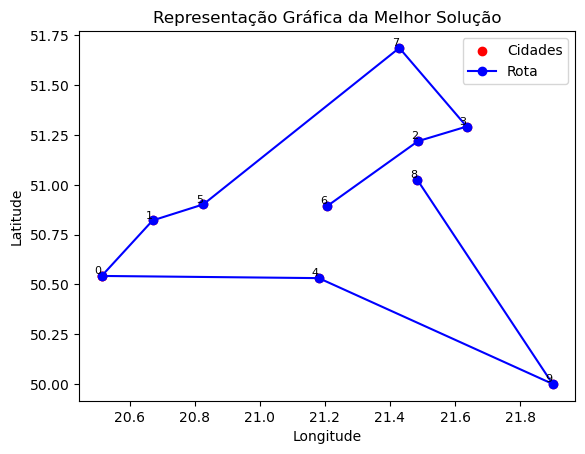

In [35]:
# Função para plotar as cidades e a rota
def plot_solution(city_locations, solution):
    # Descompacta as coordenadas das cidades
    lats, lons = zip(*city_locations)
    
    # Adiciona a primeira cidade no final para fechar o ciclo
    lats += (lats[0],)
    lons += (lons[0],)
    
    # Plota as cidades
    plt.scatter(lons, lats, color='red', marker='o', label='Cidades')
    
    # Plota a rota
    plt.plot(np.take(lons, solution), np.take(lats, solution), linestyle='-', marker='o', color='blue', label='Rota')
    
    # Adiciona rótulos para as cidades
    for i, txt in enumerate(range(len(city_locations))):
        plt.annotate(txt, (lons[i], lats[i]), fontsize=8, ha='right', va='bottom')
    
    # Adiciona legendas e títulos
    plt.legend()
    plt.title('Representação Gráfica da Melhor Solução')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Exibe o gráfico
    plt.show()

# Exemplo de uso
plot_solution(city_locations, best_solution)

In [59]:
def run_sa_experiments(distances, initial_solution, initial_temperatures, cooling_rates, num_iterations):
    results = []

    for initial_temp in initial_temperatures:
        for cooling_rate in cooling_rates:
            # Executa o Simulated Annealing para uma combinação específica de temperatura inicial e taxa de resfriamento
            best_solution = simulated_annealing(distances, initial_solution, initial_temp, cooling_rate, num_iterations)
            best_distance = objective_function(distances, best_solution)

            # Armazena os resultados
            results.append({
                'initial_temp': initial_temp,
                'cooling_rate': cooling_rate,
                'best_solution': best_solution,
                'best_distance': best_distance
            })

    return results

# Configurações para experimentos
initial_temperatures = [1000, 5000, 10000]
cooling_rates = [0.95, 0.98, 0.99]
num_iterations = 10000

# Executa experimentos
experiment_results = run_sa_experiments(distances, initial_solution, initial_temperatures, cooling_rates, num_iterations)

# Imprime os resultados
for result in experiment_results:
    print(f"Initial_temperature {result['initial_temp']}, Colling Rate: {result['cooling_rate']}")
    print(f"Melhor Solução: {result['best_solution']}")
    print(f"Distância da Melhor Solução: {result['best_distance']}")
    print("\n")

Initial_temperature 1000, Colling Rate: 0.95
Melhor Solução: [2 3 5 8 9 6 7 1 0 4]
Distância da Melhor Solução: 650.122634654912


Initial_temperature 1000, Colling Rate: 0.98
Melhor Solução: [7 6 2 0 4 3 1 9 8 5]
Distância da Melhor Solução: 638.9861254530447


Initial_temperature 1000, Colling Rate: 0.99
Melhor Solução: [7 2 4 0 5 8 9 1 6 3]
Distância da Melhor Solução: 591.8823142687645


Initial_temperature 5000, Colling Rate: 0.95
Melhor Solução: [4 2 3 6 7 1 9 8 5 0]
Distância da Melhor Solução: 620.57537455596


Initial_temperature 5000, Colling Rate: 0.98
Melhor Solução: [2 4 0 5 8 9 1 7 6 3]
Distância da Melhor Solução: 547.7199146712048


Initial_temperature 5000, Colling Rate: 0.99
Melhor Solução: [2 3 6 7 1 9 8 5 0 4]
Distância da Melhor Solução: 555.9924688157155


Initial_temperature 10000, Colling Rate: 0.95
Melhor Solução: [7 3 2 4 0 5 8 9 1 6]
Distância da Melhor Solução: 594.2402140251534


Initial_temperature 10000, Colling Rate: 0.98
Melhor Solução: [1 9 8 5 0 4 2 3

** NECESSÁRIO COLOCAR POR OUTRAS PALAVRAS! A escolha da estratégia de vizinhança pode ter um impacto significativo no desempenho do algoritmo Simulated Annealing. Se a atualização não for aleatória e sempre escolher a vizinhança onde a distância é a maior, isso pode afetar a capacidade do algoritmo de escapar de mínimos locais e encontrar soluções melhores. Ao escolher a vizinhança onde a distância é a maior, o algoritmo pode ficar preso em ótimos locais subótimos sem explorar outras regiões do espaço de busca. Isso pode resultar em soluções que não são tão boas quanto poderiam ser se o algoritmo tivesse explorado mais amplamente o espaço de solução.A aleatoriedade na escolha da vizinhança permite que o algoritmo explore diferentes regiões do espaço de busca, o que é benéfico para escapar de mínimos locais e encontrar soluções mais próximas do ótimo global.Em resumo, é geralmente recomendado manter alguma aleatoriedade na escolha da vizinhança durante o Simulated Annealing para garantir uma exploração mais ampla do espaço de solução e aumentar as chances de encontrar soluções de melhor qualidade.**

# Desafio - Programação 

Dependendo do algoritmo escolhido, responde às seguintes questões (com suporte gráfico, quando necessário).

**Simulated Annealing**:
1. Codifica um algoritmo capaz de fazer uma procura pelo ótimo global.
2. Testa várias combinações de Temperatura Inicial e de método de atualização de Temperatura, e comenta sobre o impacto que esta atualização e valor tem no resultado final do modelo.
3. Cria mais do que um conceito de vizinhança para a velocidade de convergência do modelo? 
    * Sugestão Vizinhança 1: A vizinhança de uma solução atual, é uma solução em que duas cidades trocam de posição (e.g. [1,2,3] passa para [1,3,2])
    * Sugestão de Vizinhança 2: A vizinhança consiste em todas as cidades na mesma posição à excepção de uma que passa a ser a última cidade (e.g. [2,4,5,1,3] passa para [2,5,1,3,4]  
3. O que acontece ao modelo se a atualização não for aleatória, mas passar a ser sempre aquela em que a distância é a maior? Este modelo tem melhores resultados?

**Algoritmo Genético**:
1. Codifica um algoritmo capaz de fazer uma procura pelo ótimo global.
2. Explica a escolha de representação do cromossoma, e a maneira como as duas operações de reprodução foram codificadas:
    * mutação
    * cross-over
3. O que acontece ao modelo se a atualização não for aleatória, mas passar a ser sempre aquela em que a distância é a maior? Este modelo tem melhores resultados?